# Openslide Test 

- **openslide**
    - get_thumbnail,
    - read_region
    - DeepZoomGenerator

In [1]:
import os.path as osp
import openslide
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from skimage.filters import threshold_otsu

from openslide.deepzoom import DeepZoomGenerator

import cv2
from keras.utils.np_utils import to_categorical

# network

from keras.models import Sequential
from keras.layers import Lambda, Dropout
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D

# train

from sklearn.model_selection import StratifiedShuffleSplit
from datetime import datetime

# evaluate

import matplotlib.gridspec as gridspec
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

Using TensorFlow backend.


In [9]:
import math
from PIL import Image
from xml.etree.ElementTree import ElementTree, Element, SubElement
from io import BytesIO

In [2]:
slide_path = 'data/train/image/positive/Slide001.mrxs'
slide = openslide.open_slide(slide_path)

BASE_TRUTH_DIR = Path('data/train/mask')
truth_path = str(BASE_TRUTH_DIR/'positive/Slide001.png')
truth = openslide.open_slide(truth_path)

print("original slide dimensions %dx%d" % slide.dimensions)
print("original truth dimensions %dx%d" % truth.dimensions)

original slide dimensions 93970x234042
original truth dimensions 5316x10007


# 1-1  DeepZoomGenerator

In [4]:
openslide.PROPERTY_NAME_BOUNDS_X

'openslide.bounds-x'

In [ ]:
# input

tile_size = 256
overlap = 0
limit_bounds = False


In [14]:
BOUNDS_OFFSET_PROPS = (openslide.PROPERTY_NAME_BOUNDS_X,
                openslide.PROPERTY_NAME_BOUNDS_Y)
BOUNDS_SIZE_PROPS = (openslide.PROPERTY_NAME_BOUNDS_WIDTH,
                openslide.PROPERTY_NAME_BOUNDS_HEIGHT)

In [15]:
BOUNDS_OFFSET_PROPS

('openslide.bounds-x', 'openslide.bounds-y')

In [16]:
BOUNDS_SIZE_PROPS

('openslide.bounds-width', 'openslide.bounds-height')

In [22]:
int(slide.properties.get('openslide.bounds-x',0))

7756

In [23]:
int(slide.properties.get('openslide.bounds-y',0))

39069

In [24]:
int(slide.properties.get('openslide.bounds-width'))

85052

In [25]:
int(slide.properties.get('openslide.bounds-height'))

160111

In [29]:
int(slide.properties.get('openslide.bounds-width'))+int(slide.properties.get('openslide.bounds-x',0))

92808

In [33]:
int(slide.properties.get('openslide.bounds-y',0))+int(slide.properties.get('openslide.bounds-height'))

199180

In [32]:
slide.dimensions

(93970, 234042)

## min offset 관련

- 이게 오히려 맞는 것 같은데

- 굳이 min offset 안들고 오더라도 충분히 구할 수 있는 거 아닌가 싶음


In [39]:
list(zip(BOUNDS_SIZE_PROPS, slide.dimensions)) 

[('openslide.bounds-width', 93970), ('openslide.bounds-height', 234042)]

In [43]:
slide.properties.get('openslide.bounds-width', 93970) # ==int(slide.properties.get('openslide.bounds-width'))

'85052'

In [36]:
size_scale = tuple(int(slide.properties.get(prop, l0_lim)) / l0_lim
                        for prop, l0_lim in zip(BOUNDS_SIZE_PROPS,
                        slide.dimensions))

In [37]:
size_scale

(0.905097371501543, 0.6841122533562352)

In [62]:
# function variable
_osr = slide
_z_t_downsample = 256
_z_overlap = 0
_limit_bounds = True



# if limit_bounds = True

In [65]:
slide.level_dimensions

((93970, 234042),
 (46985, 117021),
 (23492, 58510),
 (11746, 29255),
 (5873, 14627),
 (2936, 7313),
 (1468, 3656),
 (734, 1828),
 (367, 914),
 (183, 457))

In [45]:
_l_dimensions = tuple(tuple(int(math.ceil(l_lim * scale))
                        for l_lim, scale in zip(l_size, size_scale))
                        for l_size in slide.level_dimensions)

In [46]:
_l_dimensions

((85052, 160111),
 (42526, 80056),
 (21263, 40028),
 (10632, 20014),
 (5316, 10007),
 (2658, 5003),
 (1329, 2502),
 (665, 1251),
 (333, 626),
 (166, 313))

In [47]:
_l0_dimensions = _l_dimensions[0]

# Deep Zoom level

In [48]:
z_size = _l0_dimensions
z_dimensions = [z_size]

In [49]:
z_dimensions

[(85052, 160111)]

In [50]:
while z_size[0] > 1 or z_size[1] > 1:
    z_size = tuple(max(1, int(math.ceil(z / 2))) for z in z_size)
    z_dimensions.append(z_size)

In [51]:
z_dimensions

[(85052, 160111),
 (42526, 80056),
 (21263, 40028),
 (10632, 20014),
 (5316, 10007),
 (2658, 5004),
 (1329, 2502),
 (665, 1251),
 (333, 626),
 (167, 313),
 (84, 157),
 (42, 79),
 (21, 40),
 (11, 20),
 (6, 10),
 (3, 5),
 (2, 3),
 (1, 2),
 (1, 1)]

In [52]:
_z_dimensions = tuple(reversed(z_dimensions))

In [53]:
_z_dimensions

((1, 1),
 (1, 2),
 (2, 3),
 (3, 5),
 (6, 10),
 (11, 20),
 (21, 40),
 (42, 79),
 (84, 157),
 (167, 313),
 (333, 626),
 (665, 1251),
 (1329, 2502),
 (2658, 5004),
 (5316, 10007),
 (10632, 20014),
 (21263, 40028),
 (42526, 80056),
 (85052, 160111))

# Tile

In [55]:
tiles = lambda z_lim: int(math.ceil(z_lim / _z_t_downsample))

In [63]:
_z_t_downsample

256

In [68]:
_z_dimensions

((1, 1),
 (1, 2),
 (2, 3),
 (3, 5),
 (6, 10),
 (11, 20),
 (21, 40),
 (42, 79),
 (84, 157),
 (167, 313),
 (333, 626),
 (665, 1251),
 (1329, 2502),
 (2658, 5004),
 (5316, 10007),
 (10632, 20014),
 (21263, 40028),
 (42526, 80056),
 (85052, 160111))

In [66]:
_t_dimensions = tuple((tiles(z_w), tiles(z_h))
                    for z_w, z_h in _z_dimensions)

In [67]:
_t_dimensions

((1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 1),
 (1, 2),
 (2, 3),
 (3, 5),
 (6, 10),
 (11, 20),
 (21, 40),
 (42, 79),
 (84, 157),
 (167, 313),
 (333, 626))

# Deep Zoom level count

In [70]:
_dz_levels = len(_z_dimensions)

In [134]:
_dz_levels

19

# Total downsamples for each Deep Zoom level

In [71]:
l0_z_downsamples = tuple(2 ** (_dz_levels - dz_level - 1)
                    for dz_level in range(_dz_levels))

In [133]:
l0_z_downsamples

(262144,
 131072,
 65536,
 32768,
 16384,
 8192,
 4096,
 2048,
 1024,
 512,
 256,
 128,
 64,
 32,
 16,
 8,
 4,
 2,
 1)

In [135]:
_slide_from_dz_level = tuple(
                    _osr.get_best_level_for_downsample(d)
                    for d in l0_z_downsamples)

In [136]:
_slide_from_dz_level

(9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0)

In [137]:
_l0_l_downsamples = _osr.level_downsamples

In [138]:
_l0_l_downsamples

(1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)

In [140]:
_l_z_downsamples = tuple(
                    l0_z_downsamples[dz_level] /
                    _l0_l_downsamples[_slide_from_dz_level[dz_level]]
                    for dz_level in range(_dz_levels))


In [141]:
_l_z_downsamples

(512.0,
 256.0,
 128.0,
 64.0,
 32.0,
 16.0,
 8.0,
 4.0,
 2.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0)

In [143]:
tiles = DeepZoomGenerator(slide, tile_size=256, overlap=0, limit_bounds=False)

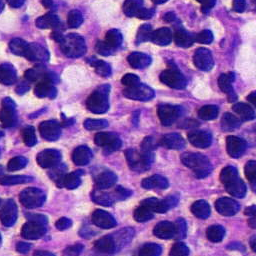

In [163]:
tiles.get_tile(tiles.level_count-1, (300.70,200.61328125))

In [73]:
openslide.PROPERTY_NAME_BACKGROUND_COLOR

'openslide.background-color'

# Slide background color

In [76]:
_bg_color = '#'+slide.properties.get(
                        openslide.PROPERTY_NAME_BACKGROUND_COLOR, 'ffffff')

# 1-2. Read_Region

In [79]:
start = (int(slide.properties.get('openslide.bounds-x',0)),int(slide.properties.get('openslide.bounds-y',0)))

In [80]:
start

(7756, 39069)

In [84]:
PATCH_SIZE  = 256
level = np.log2(PATCH_SIZE) # 되도록 레벨은 2의 거듭제곱으로 설정하자
level = int(level)

In [87]:
size = _l_dimensions[level]
size

(333, 626)

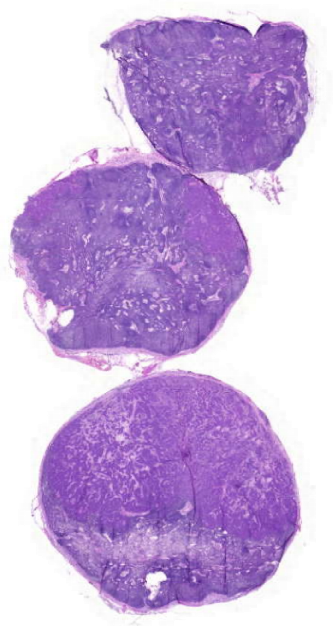

In [89]:
slide4 = slide.read_region(start,level,size)

In [128]:
np.asarray(slide4).shape

(626, 333, 4)

In [90]:
slide4.size

(333, 626)

# 1-3. Get thumbnail



In [98]:
truth.level_count # 이러면 굳이 위처럼 만드는 것보다, 위 slide4 size를 이용해서 만드는게 낫겠네

1

In [101]:
truth.dimensions

(5316, 10007)

In [123]:
downsample = max(*[dim / thumb for dim, thumb in
                zip(truth.dimensions, size)])

In [124]:
downsample

15.985623003194888

In [129]:
thumbnail_truth = truth.get_thumbnail((size))

In [131]:
thumbnail_truth
thumbnail_truth.size

(333, 626)

In [ ]:
 # 일단 이게 최선인 것 같다.